# INF8111 - Fouille de données


## TP1 AUTOMNE 2025 - Préparation de données




### Instructions de remise

#### Membres de l'équipe :
    - Pichon (2489005)
    - Nom (Matricule) 2
    - Nom (Matricule) 3

#### Numéro du groupe :
    - TP - Groupe #
    
#### Livrable :

Vous devez soumettre ce notebook sur Moodle dans la boite de remise sous le nom TP1_NumeroGroupe_matricule1_matricule2_matricule3.ipynb .

**NB**: Tout travail en retard sera pénalisé d'une valeur de 10\% par jour de retard.


## Introduction et objectifs

### Importation des différents modules

In [185]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn import linear_model
import shap

### Lecture des données

In [186]:
df = pd.read_csv('data.csv')

Le but de ce notebook est d'effectuer le prétraitement du dataset [HousePricePrediction](https://docs.google.com/spreadsheets/d/1caaR9pT24GNmq3rDQpMiIMJrmiTGarbs/edit#gid=1150341366) qui pourra être par la suite être utilisé pour entraîner un modèle de prédiction de prix de maisons.

## Préparation des données

Plusieurs étapes sont nécessaires pour préparer un dataset pour la fouille des données
- **Nettoyage des données** :
    - Suppression des attributs inutiles
    - Gestion des valeurs manquantes
    - Gestion des valeurs aberrantes
- **Transformation des données** :
    - Encodage des données
    - Normalisation des données
- **Sélection des attributs** :
    - Suppression des attributs les plus fortement corrélés

<a id="exploration-des-donnees"></a>
## 1. Exploration des données (5 points)

Nous vous avons fourni le fichier *data.csv* avec l'exécution de la deuxième cellule. Il contient l'ensemble des données. Chaque ligne contient les données d'une vente. La description des attributs du dataset est la suivante:

| # | Feature Name | Description |
|---|--------------|-------------|
| 1 | Id           | Numéro de vente / To count the records. |
| 2 | MSSubClass   | Type de logement / Identifies the type of dwelling involved in the sale. |
| 3 | MSZoning     | Zonage / Identifies the general zoning classification of the sale. |
| 4 | LotArea      | Superficie du logement / Lot size in square feet. |
| 5 | LotConfig    | Configuration du logement / Configuration of the lot |
| 6 | BldgType     | Type de logement / Type of dwelling |
| 7 | OverallCond  | Etat général / Rates the overall condition of the house |
| 8 | YearBuilt    | Année de contruction / Original construction year |
| 9 | YearRemodAdd | Année de rénovation / Remodel date (same as construction date if no remodeling or additions). |
| 10| Exterior1st  | Type de revêtement extérieur / Exterior covering on house |
| 11| BsmtFinSF2   | Surface de vie / Type 2 finished square feet. |
| 12| TotalBsmtSF  | Surface totale de la base / Total square feet of basement area |
| 13| SalePrice    | Prix de vente à prédire / To be predicted |

On visualise le dataset pour avoir une idée de ce qu'il contient et des prétraitements à effectuer.

### 1.1 - Question 1 (2.5 points)

**Combien d'observations contient le dataset ? Quelles sont les types des attributs du dataset ?**

In [187]:
print("Nombre de lignes:", df.shape[0])

print("Nombre de colonnes:", df.shape[1])

print("\nTypes des attribut:\n")
print(df.dtypes)

Nombre de lignes: 2919
Nombre de colonnes: 13

Types des attribut:

Id                int64
MSSubClass        int64
MSZoning         object
LotArea           int64
LotConfig        object
BldgType         object
OverallCond       int64
YearBuilt         int64
YearRemodAdd      int64
Exterior1st      object
BsmtFinSF2      float64
TotalBsmtSF     float64
SalePrice       float64
dtype: object


### 1.2 - Question 2 (2.5 points)

**Quelles sont les valeurs uniques des attributs de type `object` ?**

In [188]:
colonnes_object = df.select_dtypes(include=['object']).columns

for colonne in colonnes_object:
    print(f"\n{colonne}:")
    print(df[colonne].unique())


MSZoning:
['RL' 'RM' 'C (all)' 'FV' 'RH' nan]

LotConfig:
['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']

BldgType:
['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']

Exterior1st:
['VinylSd' 'MetalSd' 'Wd Sdng' 'HdBoard' 'BrkFace' 'WdShing' 'CemntBd'
 'Plywood' 'AsbShng' 'Stucco' 'BrkComm' 'AsphShn' 'Stone' 'ImStucc'
 'CBlock' nan]


<a id="nettoyage-des-donnees"></a>
## 2. Nettoyage des données (30 points)

<a id="suppression-des-attributs-inutiles"></a>
### 2.1 Suppression des attributs inutiles

### 2.1.1 - Question 3 (5 points)

**Pourquoi on peut supprimer l'attribut `Id` dans le cas de ce TP? Effectuez cette suppression.**

Dans le cas du TP, on peut supprimer l'attribut Id car il ne contient aucune information
pertinente pour prédire le prix de vente. En effet, l'attribut Id sert uniquement d'identifiant pour chaque maison (sans aucune logique derrière), il n'apporte aucune information utile pour expliquer ou prédire son prix. Garder cette colonne pourrait perturber l'apprentissage du modèle, car celui-ci risquerait de chercher des relations là où il n'y en a pas. On préfère donc se concentrer sur les caractéristiques réelles du logement qui ifluencent vraiment le prix et pas les identifiants qui ne donne pas d'information sur celui ci.

In [189]:

# Suppression de l'attribut Id

# Vérifier que Id existe
print(f"Nombre colonnes: {df.shape[1]}")

# Supprimer Id
df = df.drop(columns=['Id'])

# Vérifier la suppression (en verrifiant qu'il y a bien qu'une seule colonne de moins)
print(f"Nombre colonnes: {df.shape[1]}")



Nombre colonnes: 13
Nombre colonnes: 12


<a id="gestion-des-valeurs-manquantes"></a>
### 2.2 Gestion des valeurs manquantes

Pour gérer les valeurs manquantes, plusieurs solutions s'offrent à nous :
- Remplacer par la valeur la plus fréquente (le mode)
- Remplacer par la valeur moyenne/médiane
- Suppression des lignes contenant des valeurs manquantes

Pour ce TP, nous optons pour la dernière option.

#### 2.2.1 - Question 4 (2.5 points)

**Quels sont les attributs qui contiennent des valeurs manquantes ?**

In [190]:
# On récupère le nombre de valeur manquante par attribut
valeurs_manquantes = df.isnull().sum()
# Afficher seulement les colonnes ou il y a des valeurs manquante
colonnes_avec_manquantes = valeurs_manquantes[valeurs_manquantes > 0]
print(colonnes_avec_manquantes) 


MSZoning          4
Exterior1st       1
BsmtFinSF2        1
TotalBsmtSF       1
SalePrice      1459
dtype: int64


#### 2.2.2 - Question 5 (2.5 points)

On peut alors gérer les valeurs manquantes colonne par colonne. L'attribut `SalePrice` n'est pas pris en considération car les valeurs manquantes sont justement les valeurs que nous voulons prédire.

**Supprimer les lignes contenant les valeurs manquantes. Implémentez la fonction `delete_missing_values` qui retire ces données**.

In [191]:
def delete_missing_values(dataset):
   df_clean = dataset.copy()
   colonnes_a_verifier = []
   for col in df_clean.columns:
        #On ne retire pas les colonnes avec valeurs manquantes de SalePrice
        if col != 'SalePrice':
            colonnes_a_verifier.append(col)
   df_clean = df_clean.dropna(subset=colonnes_a_verifier)
   return df_clean

In [192]:
df = delete_missing_values(df)
print("Data après suppression des valeurs manquantes :")
print(f"Nombre de lignes : {df.shape[0]}")
print(f"Nombre de colonnes : {df.shape[1]}")
print("\nValeurs manquantes après nettoyage :")
print(df.isnull().sum())

Data après suppression des valeurs manquantes :
Nombre de lignes : 2913
Nombre de colonnes : 12

Valeurs manquantes après nettoyage :
MSSubClass         0
MSZoning           0
LotArea            0
LotConfig          0
BldgType           0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
Exterior1st        0
BsmtFinSF2         0
TotalBsmtSF        0
SalePrice       1453
dtype: int64


Les données manquantes pour la colonne `SalePrice` sont celles du dataset de test. On laisse donc ces valeurs manquantes car on veut appliquer le même prétraitement sur les données de test.

### 2.2.3 - Question 6 (10 points)

On veut néanmoins que les données d'entrainement suivent une distribution gaussienne.

**Implémenter le fonction `plot_hist`. Cette fonction doit permettre d'afficher la distribution des valeurs de l'attribut `SalePrice` ainsi que la loi normale de même moyenne et variance.**

In [193]:
def plot_hist(prices):
    moyenne = prices.mean()
    ecart_type = prices.std()

    plt.figure(figsize=(12, 6))
    plt.hist(prices, bins=50, alpha=0.7, color='blue', density=True, label='Prix réels')

    x = np.linspace(prices.min(), prices.max(), 100)
    y = (1/(ecart_type * np.sqrt(2*np.pi))) * np.exp(-0.5*((x-moyenne)/ecart_type)**2)
    plt.plot(x, y, color='red', linewidth=2, label='Courbe normale')

    plt.title('Distribution des prix des maisons')
    plt.xlabel('Prix')
    plt.ylabel('Fréquence')
    plt.legend()
    plt.show()

    print(f"Moyenne : {moyenne:.2f} ")
    print(f"Écart-type : {ecart_type:.2f} ")
    print(f"Prix min : {prices.min():.2f} ")
    print(f"Prix max : {prices.max():.2f} ")


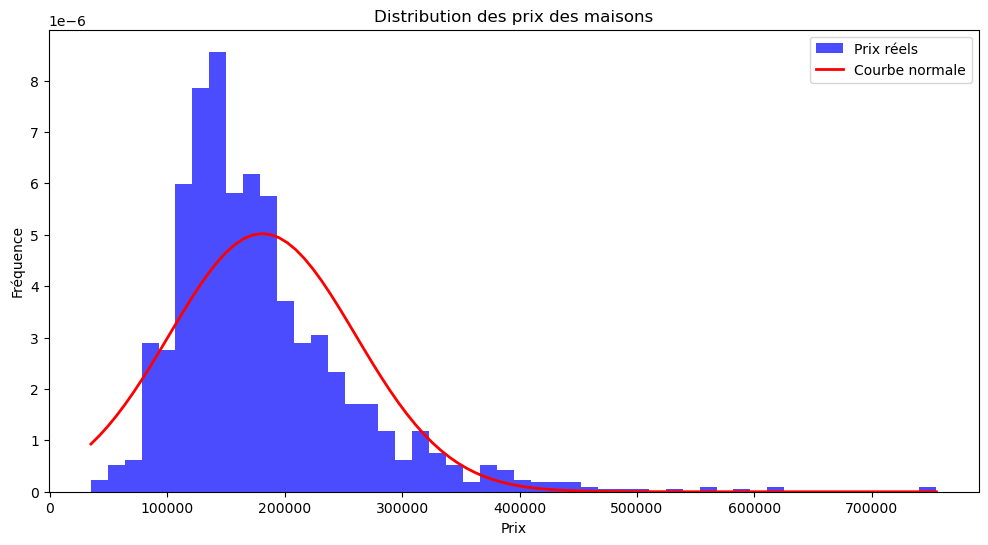

Moyenne : 180921.20 
Écart-type : 79442.50 
Prix min : 34900.00 
Prix max : 755000.00 


In [194]:
plot_hist(df['SalePrice'])

Vous devez obtenir une distribution des valeurs de `SalePrice` proches d'une distribution normale mais légèrement asymétrique. On peut alors appliquer une transformation logarithmique pour approcher d'une distribution normale symétrique.

**Effectuer cette transformation sur notre ensemble de données.**

In [195]:
#Transformation logarithmique de la distribution de SalePrice
df['SalePrice'] = np.log(df['SalePrice'])

Distribution après transformation logarithmique :


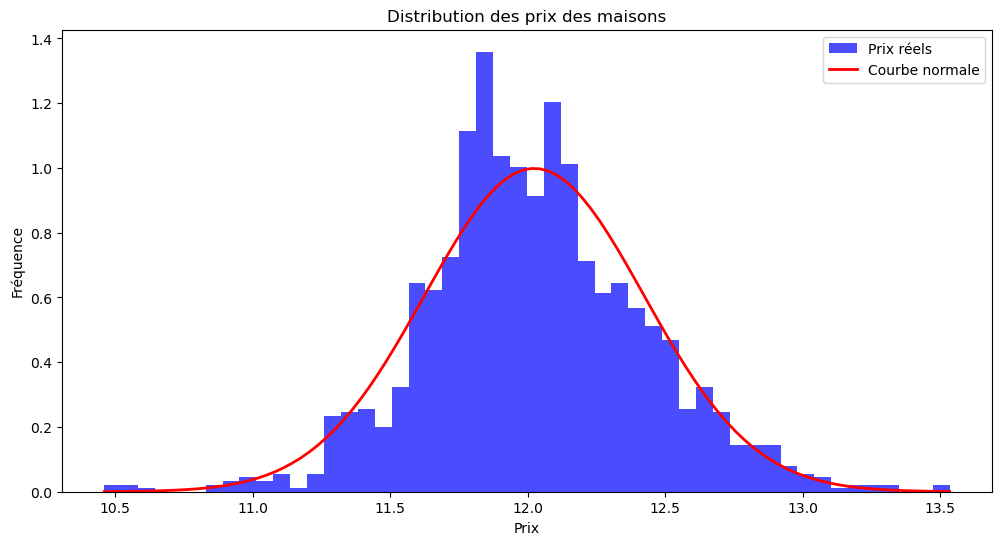

Moyenne : 12.02 
Écart-type : 0.40 
Prix min : 10.46 
Prix max : 13.53 


In [196]:
print("Distribution après transformation logarithmique :")
plot_hist(df['SalePrice'])

In [197]:
# Cette copie va servir plus tard pour la question 6 (IQR)
df_order1 = df.copy()

<a id="detection-des-valeurs-aberrantes"></a>
### 2.3 Détection des valeurs aberrantes

En pratique, la méthode de détection d'une valeur aberrante nécessite de se poser les questions suivantes:
- Quelles valeurs seraient incohérentes pour chaque colonne ?
- Quelles valeurs peuvent être problématiques pour l'utilisation de ces données ? Exemple: pour une régression linéaire, on préfère avoir des valeurs distribuées suivant une loi normale.

Avec ces éléments, on peut:
- Fixer des seuils de tolérance pour les valeurs aberrantes
- Utiliser des algorithmes de détection de valeurs aberrantes (ex: clustering, IRQ, [QTest](https://plotly.com/python/v3/outlier-test/), ...)

A noter que suivant les méthodes, les valeurs détectées comme aberrantes peuvent être différentes.

La méthode IRQ fait l'objet d'une question, en fin de ce notebook.

### 2.3.1 Question 7 (10 points)

Ici comme nous allons réaliser une régression linéaire, nous allons visuellement voir si certains points s'écartent largement de la droite de régression.

On sait que l'on veut effectuer une régression linéaire pour prédire `SalePrice`. On peut donc visualiser les valeurs de chaque attribut en fonction de `SalePrice` pour détecter la présence de valeurs aberrantes.

**Implémenter la fonction `plot_line`. Elle doit permettre de visualiser la relation entre un attribut donné et `SalePrice`.**

In [198]:
def plot_line(attr):
    plt.figure(figsize=(10, 5))
    plt.scatter(df[attr], df['SalePrice'], alpha=0.5, color='blue')
    plt.xlabel(attr)
    plt.ylabel('Prix log')
    plt.title("relation entre attribut donné et SalePrice")
    plt.show()


**Afficher les relations de tous les attributs avec `SalePrice`. Peut-on y déceler des valeurs aberrantes ?**

Analyse pour l'attribut : MSSubClass


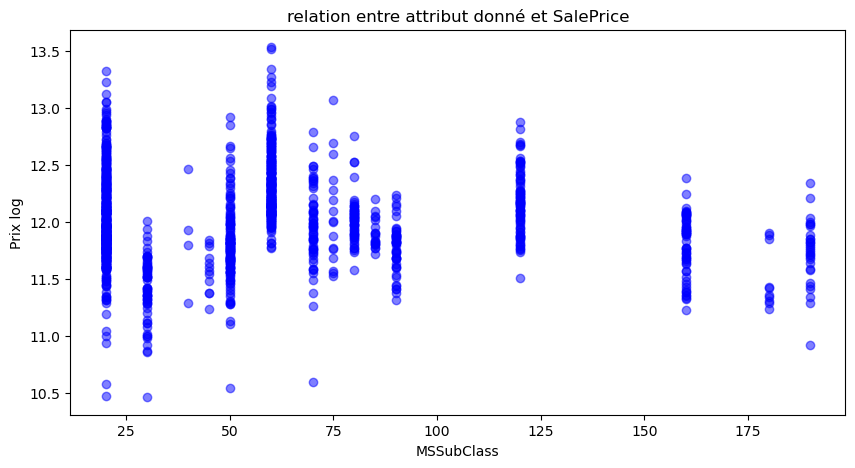

Analyse pour l'attribut : MSZoning


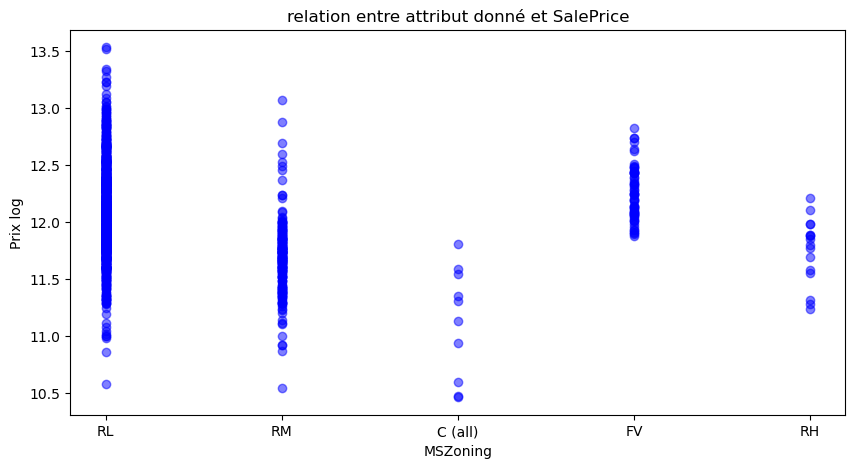

Analyse pour l'attribut : LotArea


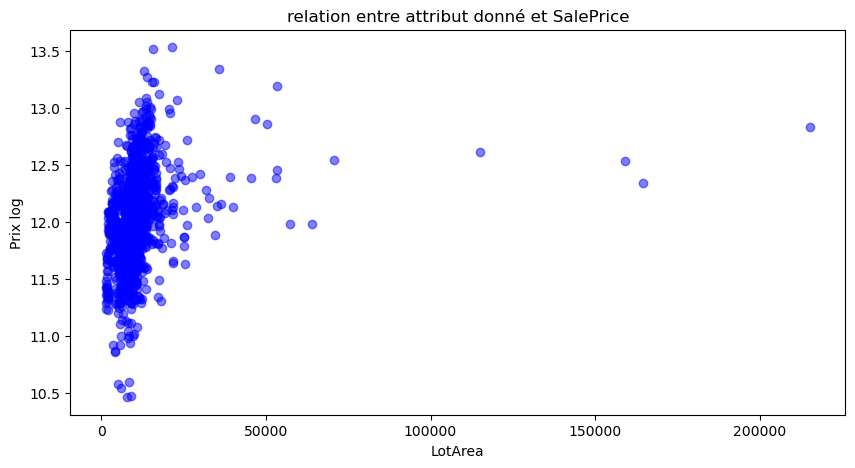

Analyse pour l'attribut : LotConfig


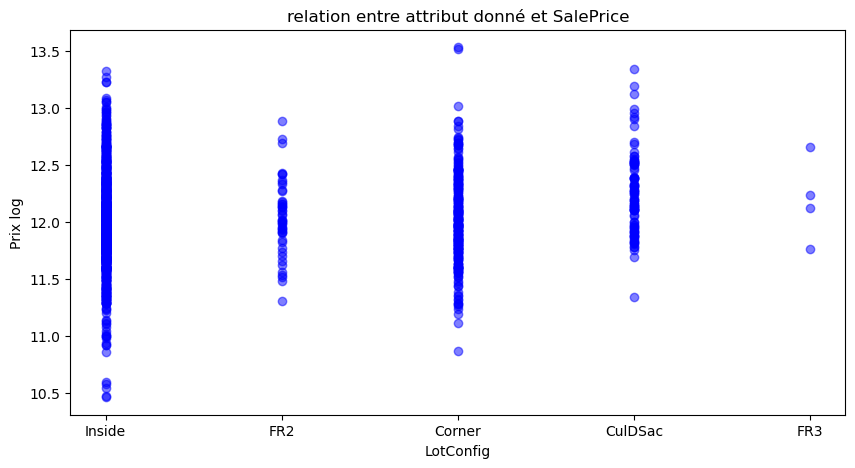

Analyse pour l'attribut : BldgType


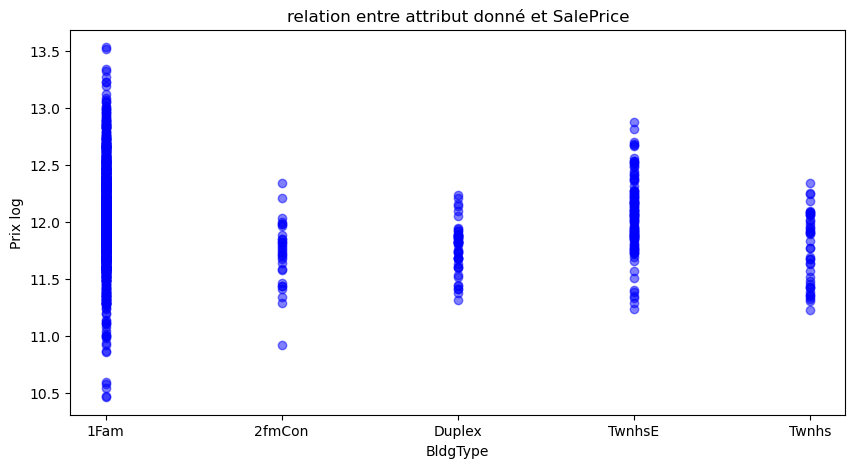

Analyse pour l'attribut : OverallCond


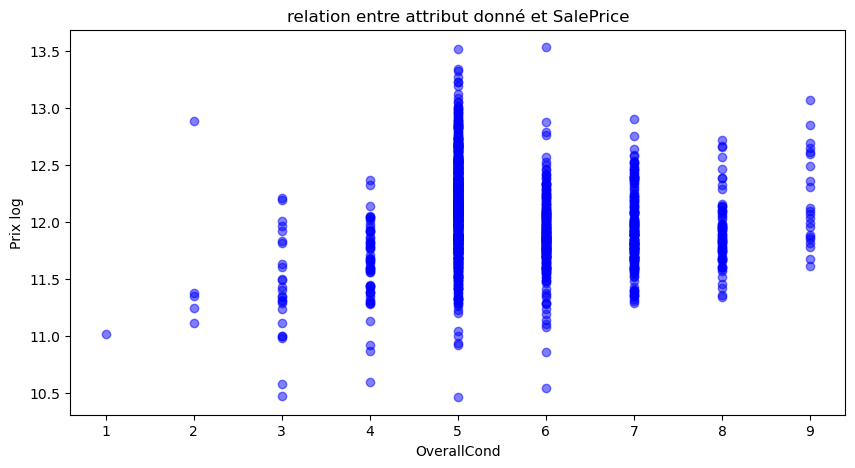

Analyse pour l'attribut : YearBuilt


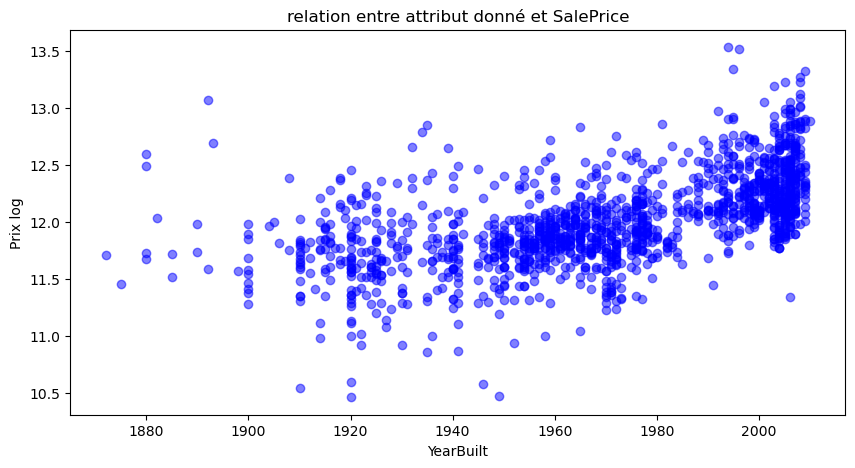

Analyse pour l'attribut : YearRemodAdd


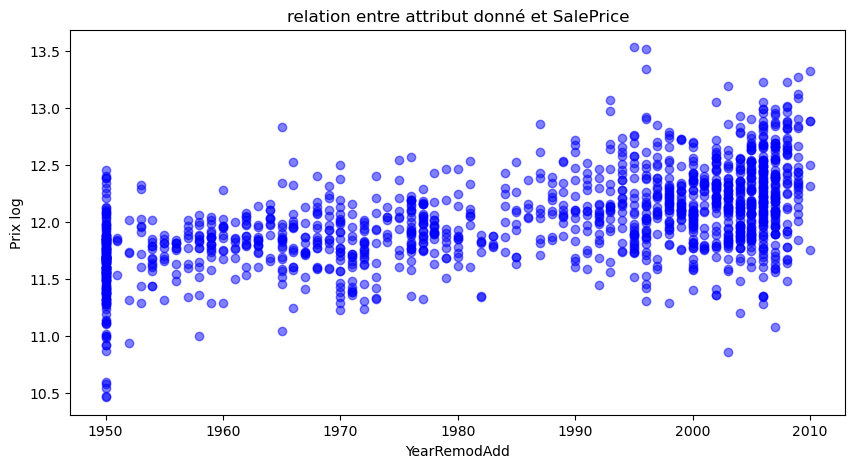

Analyse pour l'attribut : Exterior1st


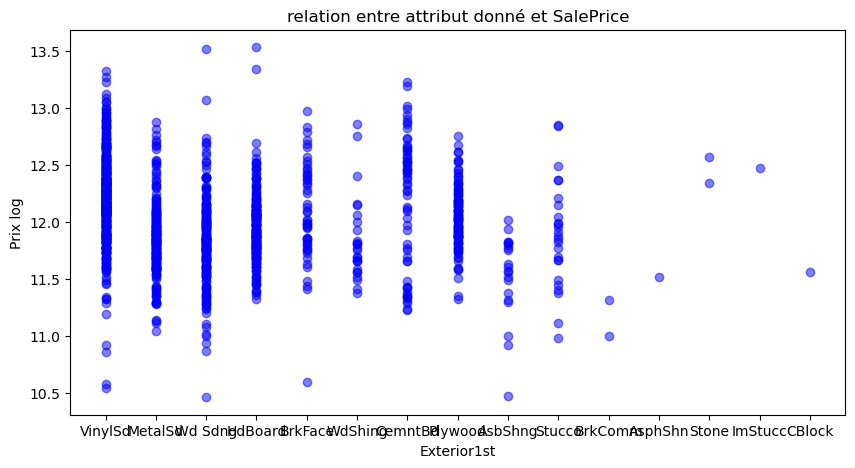

Analyse pour l'attribut : BsmtFinSF2


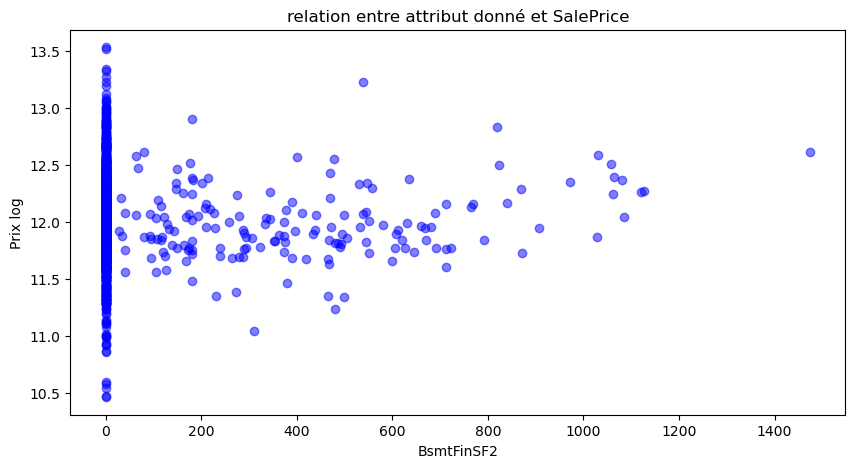

Analyse pour l'attribut : TotalBsmtSF


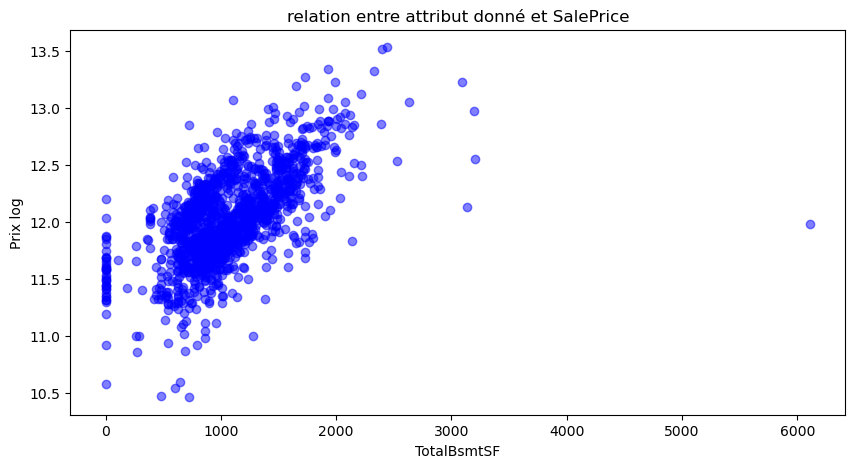

In [199]:


#Attributs a mettre en relation 
attributs = []
for col in df.columns:
    if col != 'SalePrice':
        attributs.append(col)


for attr in attributs:
    print(f"Analyse pour l'attribut : {attr}")
    plot_line(attr)



Il est possible de repérer visuellement certains points qui sont probablement des valeurs aberrantes. En effet, on les remarque car ils sont très éloignés du groupe principal dans plusieurs graphiques.

**À ce stade, il s'agit uniquement de détecter la présence éventuelle de valeurs aberrantes dans les données.**
**Aucune action de traitement ou de remplacement n'est demandée pour le moment**

## 3. Transformation des données (10 points)

### 3.1 Encodage des attributs de type `object`

Les attributs de type `object` étant catégoriques (voire partie 1), on peut effectuer un `one hot encoding` de ces attributs. `Pandas` permet d'effectuer cela avec la fonction `get_dummies()`. Cela nous permettra d'obtenir un dataset contenant uniquement des attributs de type `int` ou `float`.


#### 3.1.1 Question 8 (5 points)

**Encodez les attributs de type `object` avec un `one hot encoding`**

In [200]:

colonnes_object = []

for col in df.columns:
    if df[col].dtype == 'object':
        colonnes_object.append(col)
        
print(f"Colonnes à encoder : {colonnes_object}")


df = pd.get_dummies(df, columns=colonnes_object)

print(f"Nombre de colonnes après encodage : {df.shape[1]}")


Colonnes à encoder : ['MSZoning', 'LotConfig', 'BldgType', 'Exterior1st']
Nombre de colonnes après encodage : 38


### 3.2 Normalisation des données

Pour faciliter l'entraînement du modèle, on peut normaliser les données. `sklearn` permet d'effectuer cela avec les fonctions suivantes :

*   `StandardScaler()` normalise les données en soustrayant la moyenne et en divisant par l'écart-type
*   `MinMaxScaler()` normalise les données en les ramenant entre 0 et 1.

Dans la suite de ce TP, nous utiliserons la fonction `StandardScaler()`.

In [201]:
# A utiliser dans la partie 5.2
mu_sale_price = df["SalePrice"].mean()
sigma_sale_price = df["SalePrice"].std()

#### 3.2.1 Question 9 (5 points)

**Implémenter la fonction `normalize`. Elle doit réaliser la normalisation des données.**

In [202]:
def normalize(dataset):
    
    #On ne normalise que les float ou les entier, on prépare donc les collonne ou il n'y aura pas d'erreur dans la normalisation.
    df_normalise = dataset.copy()
    colonnes_numeriques = [col for col in df_normalise.columns if df_normalise[col].dtype in ['int64', 'float64']]
    
    
    scaler = preprocessing.StandardScaler()
    df_normalise[colonnes_numeriques] = scaler.fit_transform(df_normalise[colonnes_numeriques])
    return df_normalise


In [203]:
df = normalize(df)

#On verrifie que la normalisation est bien faites, c'est a dire que la moyenne est de O et que l'écart type est de 1
print(f"Moyenne : {df['LotArea'].mean():.3f}, Écart-type : {df['LotArea'].std():.3f} pour LotArea")
print(f"Moyenne : {df['YearBuilt'].mean():.3f}, Écart-type : {df['YearBuilt'].std():.3f} pour YearBuilt")

Moyenne : -0.000, Écart-type : 1.000 pour LotArea
Moyenne : 0.000, Écart-type : 1.000 pour YearBuilt


## 4. Sélection des attributs corrélées (15 points)

### 4.1 Suppression des attributs corrélées

Pour améliorer la qualité de la prédiction, nous devons prendre en compte la corrélation entre attributs. L'objectif est donc de supprimer les attributs les plus fortement corrélées entre eux.

Pour ce faire, vous disposez des fonctions suivantes

* `corr()` de `Pandas` qui calcule la matrice de corrélation
* `heatmap()` de `seaborn` qui permet de visualiser la matrice de corrélation


#### 4.1.1 Question 10 (10 points)

**Implémenter la fonction `display_corr_matrix`. Elle doit permettre d'afficher la matrice de corrélation entre les différents attributs de nos données après normalisation des données.**

In [204]:
def display_corr_matrix(dataset):
    #On normalise les données
    dataset = normalize(dataset)
    #On fait la matrice de corr sous la form d'un heatmap 
    matrice_correlation = dataset.corr()
    plt.figure(figsize=(20, 18))
    sns.heatmap(matrice_correlation, annot=True, cmap='coolwarm', center=0, fmt='.2f', square=True, annot_kws={"size": 8}, cbar_kws={"shrink": 0.5})
    plt.title('Matrice de Corrélation')
    plt.show()


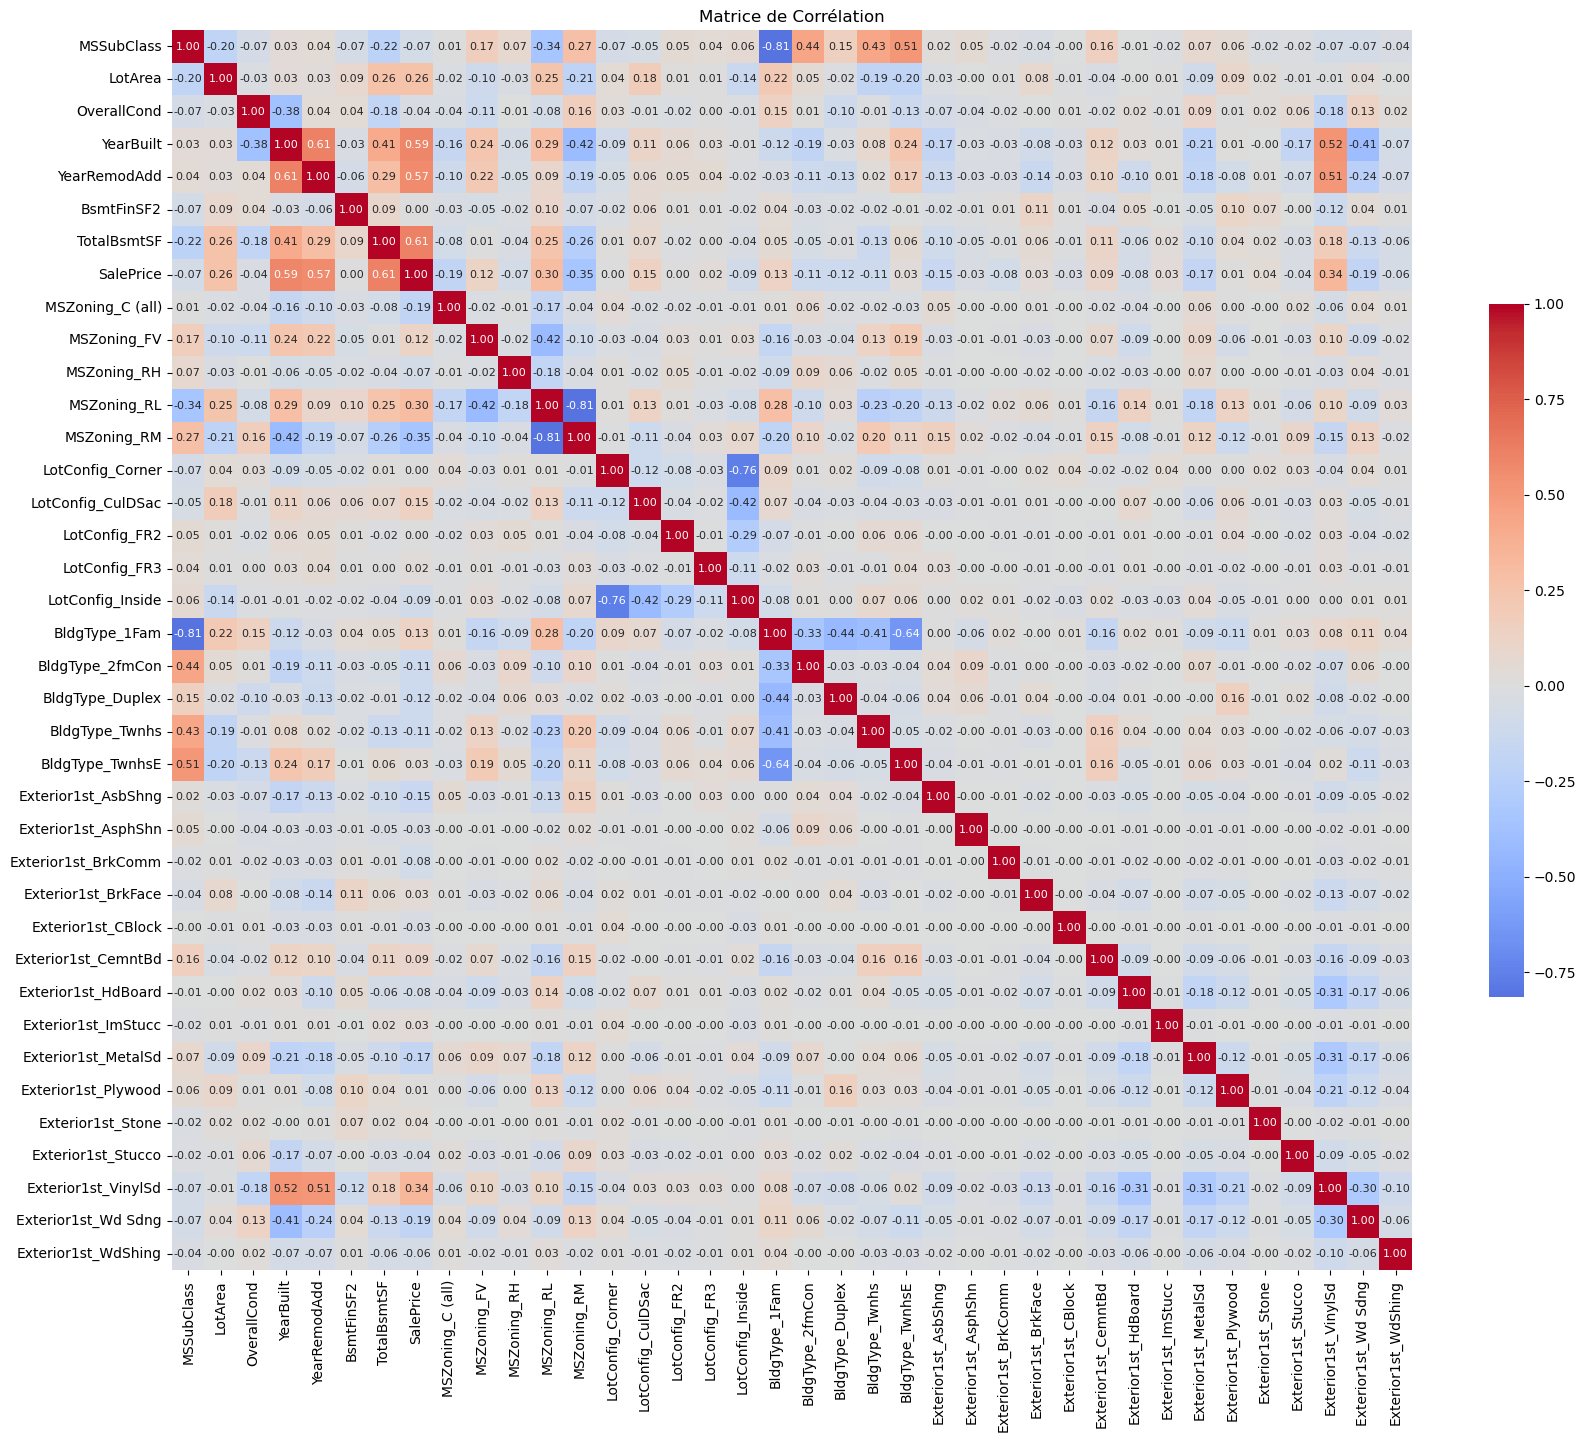

In [205]:
display_corr_matrix(df)

#### 4.1.2 Question 11 (5 points)

On peut alors choisir de supprimer les attributs qui sont fortement corrélées entre eux en définissant un seuil. Fixons ce seuil à 0.7.

**Quels sont les attributs fortement correlés selon le critère ci-dessus ? Supprimez ces attributs et affichez la nouvelle matrice de corrélation.**


Attributs supprimés : ['BldgType_1Fam', 'MSZoning_RM', 'LotConfig_Inside']


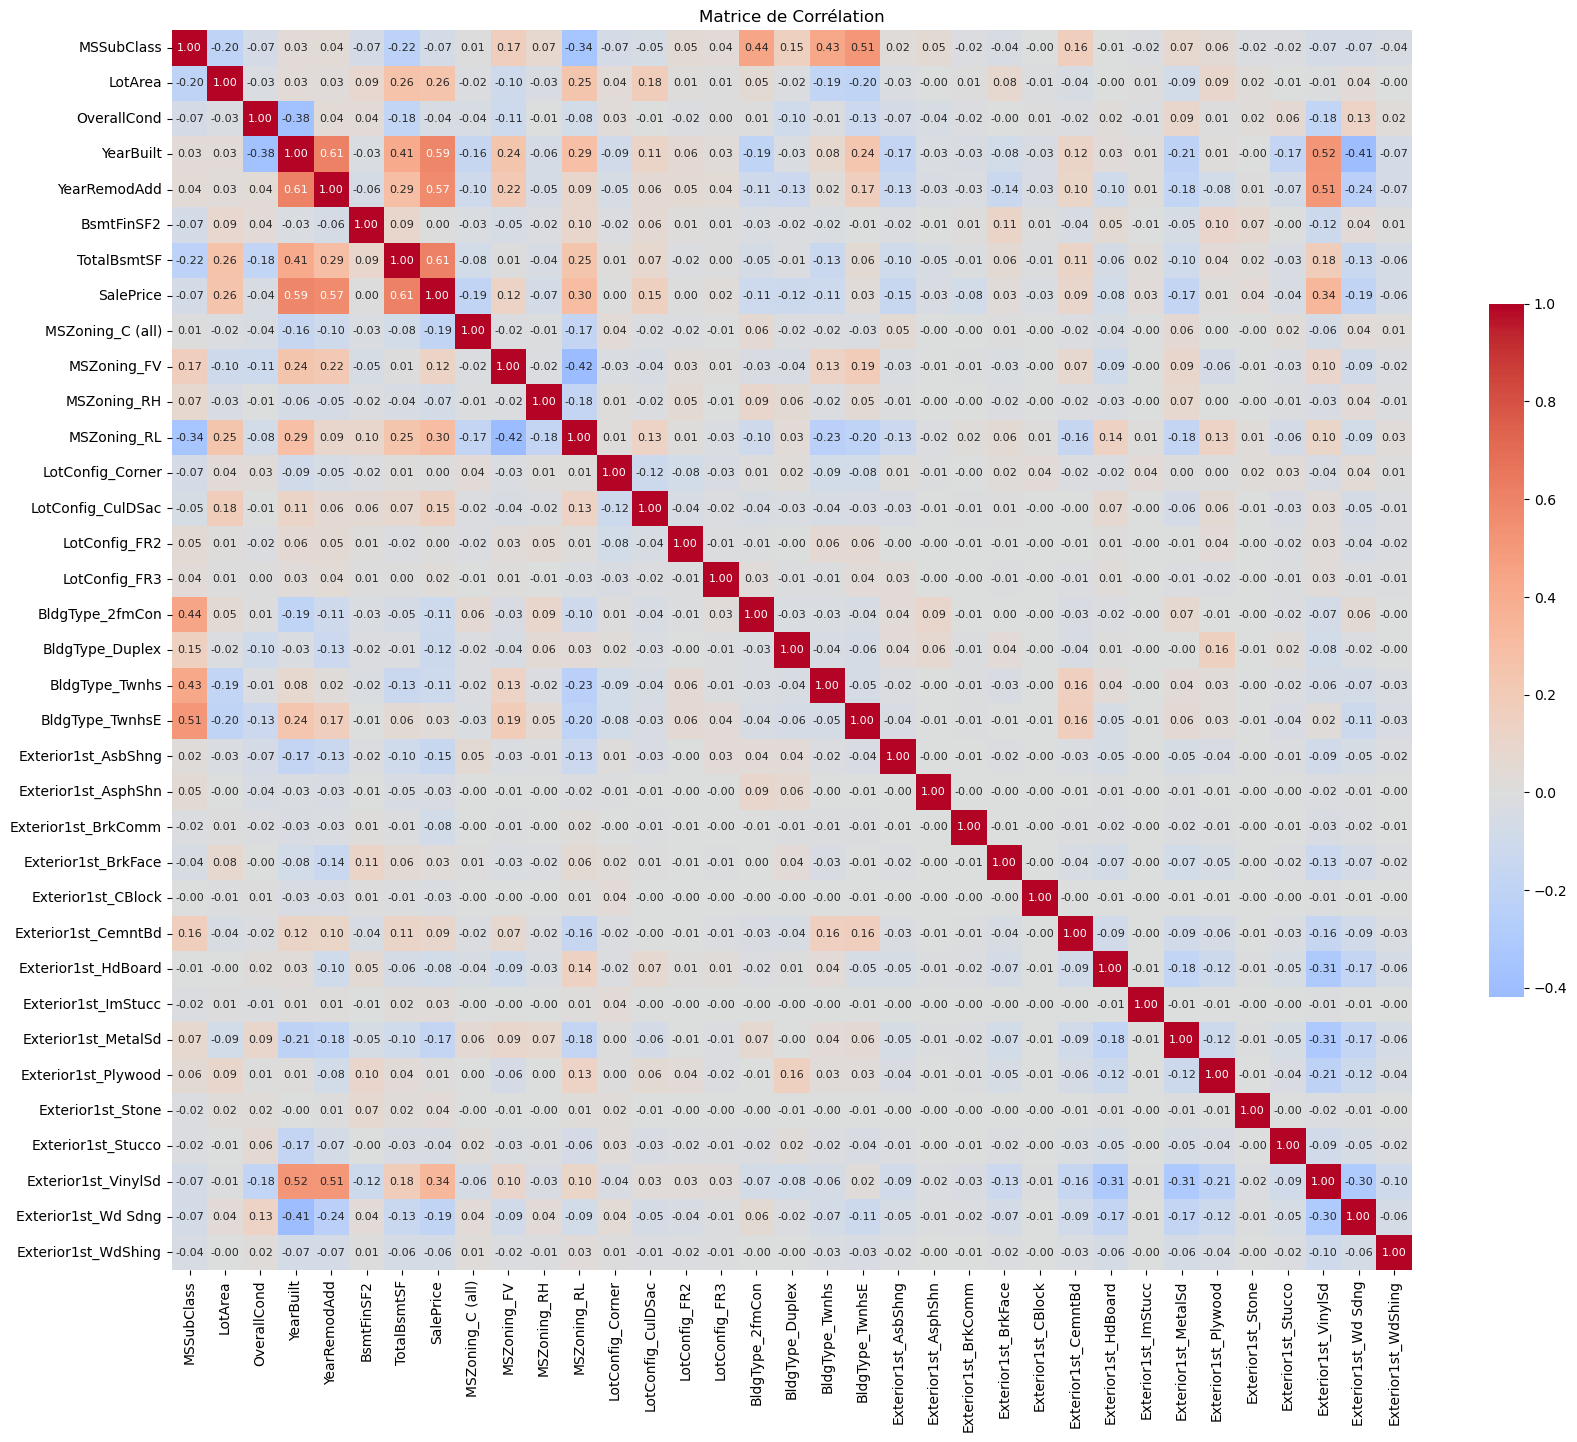

In [206]:
matrice_corr = df.corr()
seuil = 0.7

attributs_a_supprimer = []
for i in range(len(matrice_corr.columns)):
    for j in range(i+1, len(matrice_corr.columns)):
        if abs(matrice_corr.iloc[i, j]) > seuil:
            attr1 = matrice_corr.columns[i]
            attr2 = matrice_corr.columns[j]
            attributs_a_supprimer.append(attr2)

df = df.drop(columns=attributs_a_supprimer)
print(f"\nAttributs supprimés : {attributs_a_supprimer}")
display_corr_matrix(df)

## 5. Entrainement d'un modèle de régression linéaire (30 points)

### 5.1 Rappel du concept

La régression linéaire consiste à trouver une fonction affine qui minimise la somme des carrés des erreurs. La fonction affine est définie par la formule suivante :
$$ f(x) = \beta_0 + \beta_1^T x $$
Nous tentons de trouver les paramètres $\beta_0$ et $\beta_1$ qui minimisent $\sum_{i=1}^n (f(x_i) - y_i)^2=||y-X\beta||^2$ où $X$ est la matrice des données fournies au modèle et $y$ le vecteur des `SalePrice`.

On veut trouver le minimum de cette fonction. On va utiliser `RidgeRegression` de `sklearn` pour trouver les paramètres $\beta_0$ et $\beta_1$. Ce module utilise la méthode des moindres carrés (`numpy.linalg.lstsq`) pour trouver les paramètres $\beta_0$ et $\beta_1$.

### 5.2 Application

#### 5.2.1 Question 12 (5 points)

Après avoir effectué le prétraitement, on peut commencer par séparer les données en un ensemble d'entraînement et un ensemble de test. Pour cela, les 1460 premières lignes contiennent les données d'entrainement. On peut ainsi séparer les données en deux ensembles.

**Compléter la structure suivante afin de diviser les données en deux sous-ensembles.**

In [207]:

data_train = {"x": df.iloc[:1460].drop(columns=['SalePrice']), "y": df.iloc[:1460]['SalePrice'], "df": df.iloc[:1460]}

data_pred = { "x": df.iloc[1460:].drop(columns=['SalePrice']),  "df": df.iloc[1460:] }


#### 5.2.2 Question 13 (7.5 points)

Une fois cette séparation faite, on peut utiliser `RidgeRegression` pour effectuer la régression linéaire avec pénalisation de la norme L2.

**Compléter la fonction `ridge_regression`. Elle doit implémenter l'ensemble de la régression.**

*Pour cette question, vous devez retourner les coefficients de la regression linéaire. De plus, cette fonction doit modifier le paramètre `data_pred` en y ajoutant les valeurs prédites.*

**Remarques**:
- La fonction doit retourner un dictionnaire dont les clés sont les noms des attributs et les valeurs, les coefficients correspondants.
- Dans `data_pred`, ajoutez deux colonnes : une première contenant les prédictions (sortie du modèle), et une deuxième avec les prédictions remises à l’échelle originale des prix, en inversant la standardisation et la transformation logarithmique.

In [218]:
def ridge_regression(data_train, data_pred):
    
    model = linear_model.Ridge(alpha=1.0)
    model.fit(data_train["x"], data_train["y"])

    predictions_normalisees_log = model.predict(data_pred["x"])
    predictions_log = (predictions_normalisees_log * sigma_sale_price) + mu_sale_price
    predictions_reelles = np.exp(predictions_log)

    data_pred["y"] = predictions_normalisees_log
    data_pred["y_reel"] = predictions_reelles

    coefficients = {}
    for i, col in enumerate(data_train["x"].columns):
        coefficients[col] = model.coef_[i]
    coefficients['intercept'] = model.intercept_

    return coefficients


#### 5.2.3 Question 14 (5 points)

**À l’aide d’un histogramme, comparez la distribution des prix prédits à celle des données d’entraînement, en vous assurant que les deux sont représentées à l’échelle originale des prix (c’est-à-dire sans transformation logarithmique ni standardisation). Commentez brièvement.**

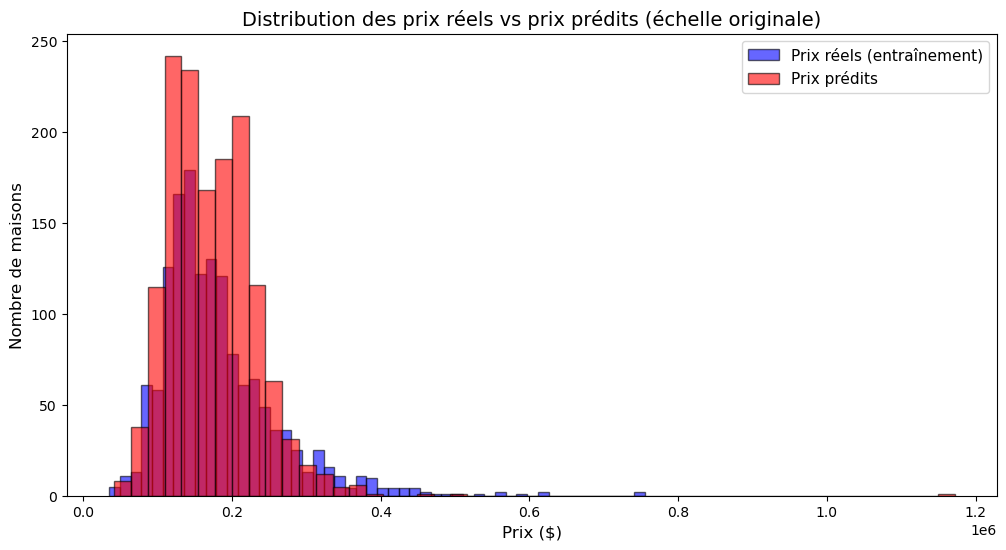

In [219]:
#remise a la bonne échelle pour comparer
prix_log_train = (data_train['y'] * sigma_sale_price) + mu_sale_price
prix_reels_train = np.exp(prix_log_train)

#préduction des prix par le modèle
prix_predits = data_pred['y_reel']

# 3. plot de l'histogramme comparatif
plt.figure(figsize=(12, 6))
plt.hist(prix_reels_train, bins=50, alpha=0.6, label='Prix réels (entraînement)', color='blue', edgecolor='black')
plt.hist(prix_predits, bins=50, alpha=0.6, label='Prix prédits', color='red', edgecolor='black')
plt.xlabel('Prix ($)', fontsize=12)
plt.ylabel('Nombre de maisons', fontsize=12)
plt.title('Distribution des prix réels vs prix prédits (échelle originale)', fontsize=14)
plt.legend(fontsize=11)
plt.show()


On remarque que la distribution des prix réel est plus étalée que celle des prix prédits. Celle des prix prédit rest entre 0 et 0.4 1e6. Cependant, on remarque que la distribution principale est cohérente et que les deux modèles ont leurs pics aux meme endroits. Notre prédictions bien que imparfaite et ne collant pas la réalitée reste cohérente.


### 5.3. Sélection des attributs importants
#### 5.3.1 Question 15 (5 points)

Une fois la prédiction obtenue, on peut maintenant mesurer l'importance de chaque attribut dans la prédicition en traçant les coefficients de la régression linéaire.

**Quels sont les dix attributs ayant le plus d'impact dans la prédiction ?**


In [222]:
coefficients = ridge_regression(data_train, data_pred)
noms_attributs = []
valeurs_coefficients = []



# Parcours de l'ensemble des attributs pour savoit lequels sont les plus important. 
for nom, valeur in coefficients.items():
    if nom != 'intercept':  # On saute l'intercept
        noms_attributs.append(nom)
        valeurs_coefficients.append(valeur)

# Création du tableau des attributs, coefficients et importances 
tableau_importance = []
for i in range(len(noms_attributs)):
    nom = noms_attributs[i]
    coef = valeurs_coefficients[i]
    importance = abs(coef)  # Valeur absolue pour l'importance
    tableau_importance.append([nom, coef, importance])


#Affichage des 10 attributs les plus importants, qui ont le plus d'influence sur le prix
tableau_importance_trie = sorted(tableau_importance, key=lambda x: x[2], reverse=True)
print("les 10 attributs les plus importants :")
for i in range(10):
    nom = tableau_importance_trie[i][0]
    coef = tableau_importance_trie[i][1]
    importance = tableau_importance_trie[i][2]
    print(f"{nom} ayant pour coef d'importance ; {coef}")




les 10 attributs les plus importants :
BldgType_Twnhs ayant pour coef d'importance ; -1.565699948244972
BldgType_2fmCon ayant pour coef d'importance ; -1.410392339029851
BldgType_TwnhsE ayant pour coef d'importance ; -1.2041596243266186
MSZoning_C (all) ayant pour coef d'importance ; -0.8504696175302903
BldgType_Duplex ayant pour coef d'importance ; -0.7853149325110771
Exterior1st_BrkComm ayant pour coef d'importance ; -0.59303255761874
Exterior1st_Stone ayant pour coef d'importance ; 0.5620368855436806
MSSubClass ayant pour coef d'importance ; 0.45670014681706056
TotalBsmtSF ayant pour coef d'importance ; 0.44659217127233186
Exterior1st_BrkFace ayant pour coef d'importance ; 0.35779445888012573


#### 5.3.2 Question 16 (7.5 points)

Cette dernière méthode n'est pas nécessairement une bonne mesure de l'importance d'un attribut. On peut utiliser la méthode SHAP (SHapley Additive exPlanations) pour effectuer la sélection des attributs.

**Les dix attributs ayant le plus d'impact dans la prédiction pour cette mesure sont-ils les mêmes que ceux de la question précédente ? Donnez une interprétation comparative de ces deux résultats**


In [225]:
model = linear_model.Ridge(alpha=1.0)
model.fit(data_train["x"], data_train["y"])

explainer = shap.LinearExplainer(model, data_train["x"])
shap_values = explainer.shap_values(data_train["x"])

importance_shap = []
for i in range(len(data_train["x"].columns)):
    importance = np.abs(shap_values[:, i]).mean()
    importance_shap.append((data_train["x"].columns[i], importance))

importance_shap.sort(key=lambda x: x[1], reverse=True)


#top 10 avec Ridge
print("Ridge :")
for i in range(10):
    print(f"{tableau_importance_trie[i][0]}  ayant pour coef d'importance ; {tableau_importance_trie[i][1]:.4f}")


print("\nSHAP :")
for i in range(10):
    print(f"{importance_shap[i][0]}  ayant pour coef d'importance ; {importance_shap[i][1]:.4f}")




Ridge :
BldgType_Twnhs  ayant pour coef d'importance ; -1.5657
BldgType_2fmCon  ayant pour coef d'importance ; -1.4104
BldgType_TwnhsE  ayant pour coef d'importance ; -1.2042
MSZoning_C (all)  ayant pour coef d'importance ; -0.8505
BldgType_Duplex  ayant pour coef d'importance ; -0.7853
Exterior1st_BrkComm  ayant pour coef d'importance ; -0.5930
Exterior1st_Stone  ayant pour coef d'importance ; 0.5620
MSSubClass  ayant pour coef d'importance ; 0.4567
TotalBsmtSF  ayant pour coef d'importance ; 0.4466
Exterior1st_BrkFace  ayant pour coef d'importance ; 0.3578

SHAP :
MSSubClass  ayant pour coef d'importance ; 0.3359
TotalBsmtSF  ayant pour coef d'importance ; 0.3268
YearBuilt  ayant pour coef d'importance ; 0.2843
YearRemodAdd  ayant pour coef d'importance ; 0.1826
BldgType_TwnhsE  ayant pour coef d'importance ; 0.1550
OverallCond  ayant pour coef d'importance ; 0.0958
BldgType_Twnhs  ayant pour coef d'importance ; 0.0903
MSZoning_RL  ayant pour coef d'importance ; 0.0831
BldgType_Duple

Interprétation : 6 attributs sur 10 sont communs entre les deux méthodes.
Ridge donne des coefficients bruts du modèle (positifs ou négatifs),
tandis que SHAP mesure la contribution réelle de chaque attribut aux prédictions.
Les différences montrent que certains attributs ont un fort coefficient
mais une faible contribution réelle, et inversement.
Les deux méthodes sont complémentaires pour comprendre l'importance des variables et nous permettes toutes les deux de savoir quels attributs sont les plus influents pour la prédiction du prix de vente.

## 6. Méthode des écarts interquartiles ou IRQ (10 points)

On peut également détecter les valeurs aberrantes en affichant un boxplot de chaque colonne. On considère les valeurs comme aberrantes si elles sont situées en dehors de l'intervalle [Q1 - α * IQR, Q3 + α * IQR] où
* Q1 et Q3 sont les quantiles 25% et 75%,
* IQR l'intervalle interquartile (Q3 - Q1)
* α le facteur d'ajustement.

Pour cette question, on exclut `SalePrice` car les seules valeurs manquantes de cet attribut sont celles du dataset de test.

**Important :** Pour cette question, utilisez le jeux de données `df_order1` copié vers la fin de la section 2.

### 6.1 Question 17 (5 points)

Testez plusieurs valeurs du facteur d'ajustement α dans l'intervalle [1.5, 5] avec un pas de 0.5.
Pour chaque valeur de α :
- Calculez les bornes de détection des valeurs aberrantes (fences) pour chaque attribut numérique.
- Déterminez le nombre de valeurs aberrantes détectées pour chaque attribut.
- Affichez les résultats dans un `DataFrame`, où les lignes correspondent aux différentes valeurs de α et les colonnes correspondent aux attributs numériques.

[texte du lien](https://)**Remarque :** Vous pouvez utiliser la fonction `percentile` de `numpy` pour calculer les quantiles.

In [213]:
df_numerique = df_order1.select_dtypes(include=[np.number])
df_numerique = df_numerique.drop(columns=['SalePrice'], errors='ignore')  

alpha = np.arange(1.5, 5.5, 0.5)
resultat = {}

for a in alpha:     
    compteur_aberrantes = {}
    for attr in df_numerique.columns:  
        Q1 = np.percentile(df_order1[attr], 25)
        Q3 = np.percentile(df_order1[attr], 75) 
        IQR = Q3 - Q1
        borne_inf = Q1 - a * IQR 
        borne_sup = Q3 + a * IQR
        
        valeurs_aberrantes = df_order1[(df_order1[attr] < borne_inf) | (df_order1[attr] > borne_sup)]  
        nb_aberrantes = len(valeurs_aberrantes)     
        compteur_aberrantes[attr] = nb_aberrantes
    resultat[a] = compteur_aberrantes


# Convertir en DataFrame
df_resultats = pd.DataFrame(resultat).T  # .T pour transposer
df_resultats.index.name = 'Alpha'

print(df_resultats)
resultats_irq = df_resultats


       MSSubClass  LotArea  OverallCond  YearBuilt  YearRemodAdd  BsmtFinSF2  \
Alpha                                                                          
1.5           207      125          250          9             0         347   
2.0            78       92           57          0             0         347   
2.5             0       67           57          0             0         347   
3.0             0       51            6          0             0         347   
3.5             0       41            6          0             0         347   
4.0             0       35            0          0             0         347   
4.5             0       34            0          0             0         347   
5.0             0       31            0          0             0         347   

       TotalBsmtSF  
Alpha               
1.5            119  
2.0             22  
2.5             10  
3.0              7  
3.5              6  
4.0              2  
4.5              2  
5.0       

Visualisez les résultats dans une seule figure:
- L’axe X représente les valeurs de α.
- L’axe Y représente le nombre de valeurs aberrantes.
- Chaque courbe correspond à un attribut numérique, illustrant l’évolution du nombre de valeurs aberrantes en fonction de α.

Quelle valeur de α vous semble le mieux adaptée? Justifiez votre réponse.

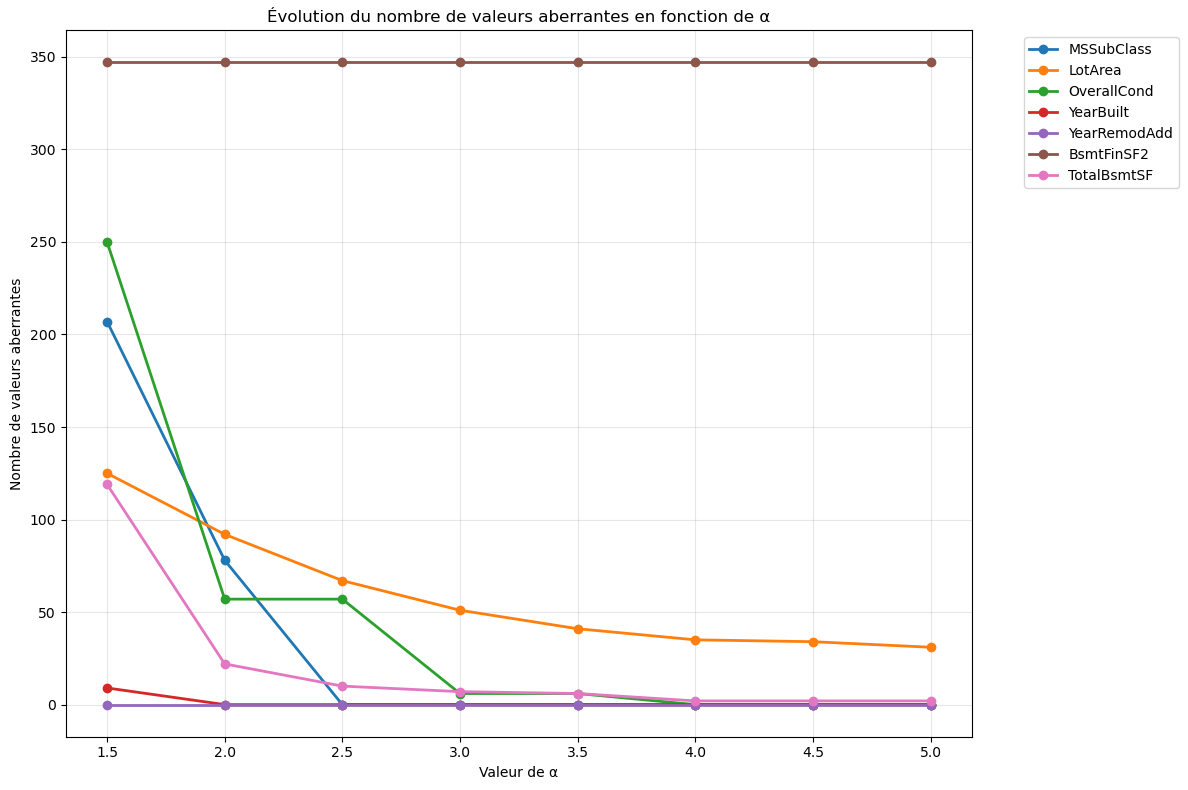

Total de valeurs aberrantes par α:
α = 1.5: 1057 valeurs aberrantes
α = 2.0: 596 valeurs aberrantes
α = 2.5: 481 valeurs aberrantes
α = 3.0: 411 valeurs aberrantes
α = 3.5: 400 valeurs aberrantes
α = 4.0: 384 valeurs aberrantes
α = 4.5: 383 valeurs aberrantes
α = 5.0: 380 valeurs aberrantes

Recommandation: α = 3.0 (411 valeurs aberrantes)


In [214]:
# Visualisation
plt.figure(figsize=(12, 8))

for i, attr in enumerate(df_numerique.columns):
    nb_aberrantes = [resultats_irq.loc[a, attr] for a in alpha]
    plt.plot(alpha, nb_aberrantes, 'o-', label=attr, linewidth=2, markersize=6)

plt.xlabel('Valeur de α')
plt.ylabel('Nombre de valeurs aberrantes')
plt.title('Évolution du nombre de valeurs aberrantes en fonction de α')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Analyse
totaux = resultats_irq.sum(axis=1)
print("Total de valeurs aberrantes par α:")
for a in alpha:
    print(f"α = {a}: {totaux[a]} valeurs aberrantes")

print(f"\nRecommandation: α = 3.0 ({totaux[3.0]} valeurs aberrantes)")

### 6.2 Question 18 (5 points)

**On  fixe le facteur d'ajustement α à `3` pour tous les attributs.**

Pour chaque attribut numérique, tracez un boxplot. Ajoutez également deux lignes horizontales représentant les bornes inférieure et supérieure de l’intervalle [Q1 - α * IQR, Q3 + α * IQR].

In [215]:
#TODO

Pour chaque attribut numérique (à l'exception de `BsmtFinSF2`), remplacez les valeurs aberrantes détectées avec α=3 par la `valeur médiane` de la colonne. Pourquoi ce remplacement n’est pas approprié pour l’attribut `BsmtFinSF2` ?

In [216]:
#TODO